## Pretraitement des données

Rapide coupr d'oeil sur notre jeu de données et sur les classes utilisées

In [2]:
# MNE Librayry https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-pyimport mne
%%capture
!pip install mne
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import pandas as pd
import mne
import seaborn as sns
import torch

## Visualisation du débalancement de classes

<ipython-input-3-eb252993173e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], data=participants_data, x='Gender', palette='pastel', edgecolor='black')
<ipython-input-3-eb252993173e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 1], data=participants_data, x='Group', palette='muted', edgecolor='black')


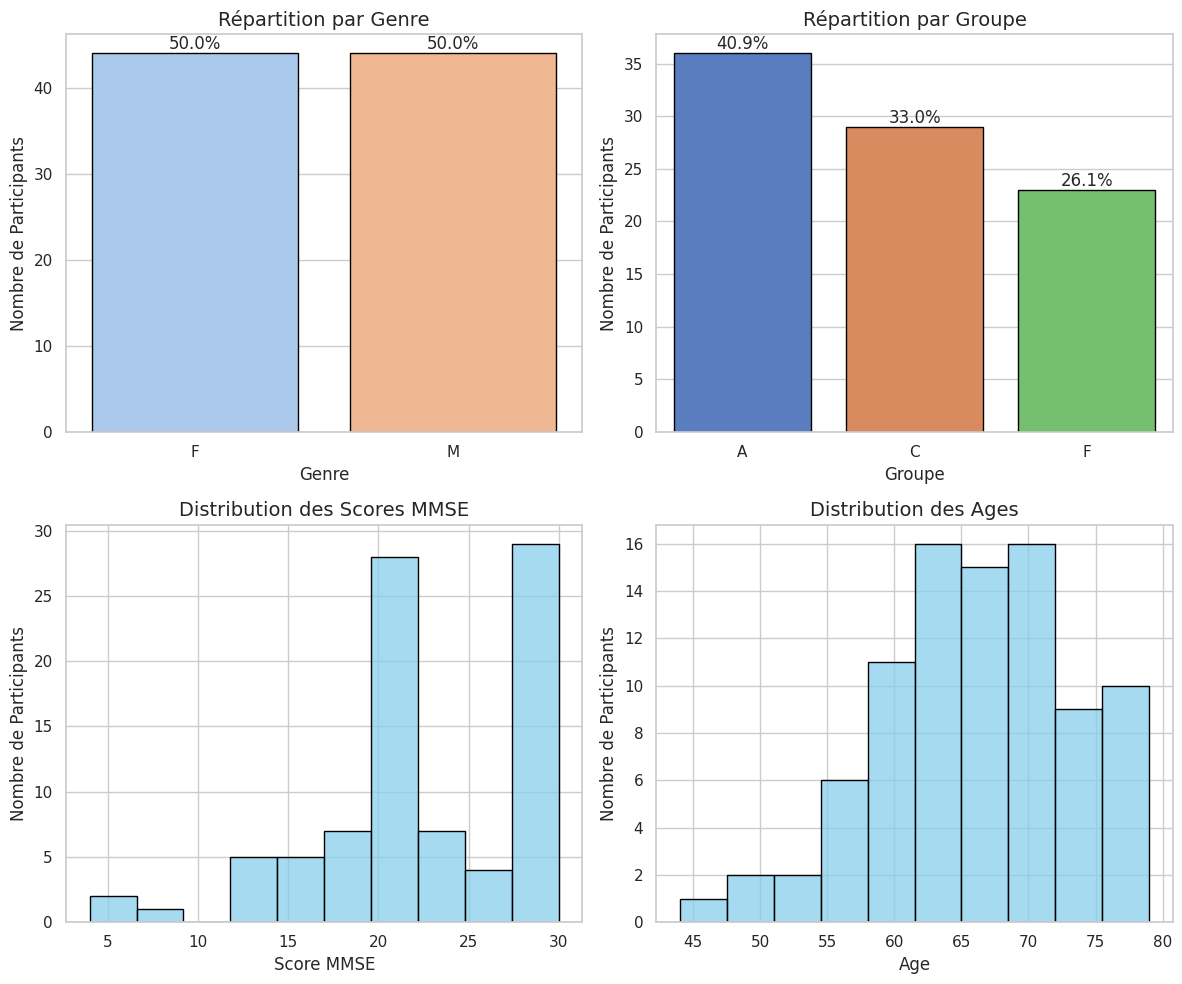

In [3]:
# On va chercher les données des participans pour des stats
path_dataset = "/content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/"
# /content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/participants.tsv
participants_data = pd.read_csv(path_dataset+"participants.tsv", sep='\t')
participants_data.head()

# Appliquer un style Seaborn
sns.set(style="whitegrid")

# Définir la taille de la figure et créer des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme des genres
sns.countplot(ax=axes[0, 0], data=participants_data, x='Gender', palette='pastel', edgecolor='black')
axes[0, 0].set_title('Répartition par Genre', fontsize=14)
axes[0, 0].set_xlabel('Genre', fontsize=12)
axes[0, 0].set_ylabel('Nombre de Participants', fontsize=12)

# Ajouter les pourcentages au-dessus des barres
total = len(participants_data['Gender'])
for p in axes[0, 0].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 0].annotate(percentage, (x, y), ha='center', va='bottom')

# Histogramme des groupes A, C, F
sns.countplot(ax=axes[0, 1], data=participants_data, x='Group', palette='muted', edgecolor='black')
axes[0, 1].set_title('Répartition par Groupe', fontsize=14)
axes[0, 1].set_xlabel('Groupe', fontsize=12)
axes[0, 1].set_ylabel('Nombre de Participants', fontsize=12)

# Ajouter les pourcentages au-dessus des barres
total = len(participants_data['Group'])
for p in axes[0, 1].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 1].annotate(percentage, (x, y), ha='center', va='bottom')

# Histogramme des scores MMSE
sns.histplot(ax=axes[1, 0], data=participants_data, x='MMSE', bins=10, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Distribution des Scores MMSE', fontsize=14)
axes[1, 0].set_xlabel('Score MMSE', fontsize=12)
axes[1, 0].set_ylabel('Nombre de Participants', fontsize=12)

# Histogramme des Ages
sns.histplot(ax=axes[1, 1], data=participants_data, x='Age', bins=10, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Distribution des Ages', fontsize=14)
axes[1, 1].set_xlabel('Age', fontsize=12)
axes[1, 1].set_ylabel('Nombre de Participants', fontsize=12)

plt.tight_layout()
plt.show()

## Création de différents datasets pour faciliter l'analyse

In [ ]:
# ========================================
# ==== Creation des jeux de donnees ===========
# ========================================

import mne
import torch
import numpy as np
import pandas as pd
# get all speech
# contenir des listes des 19 canaux pour les 88 patient
all_spectres = []
all_spectres_canal = []
#all_phases = []


# les raw des patients
liste_de_rats = []

# pour les echantillonnages
all_wav_patient = []
all_fs_patient = []

path_dataset = "/content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/derivatives/"
# path_dataset = "/content/drive/MyDrive/MSLP/Project/Projet_Session-EEG-Alza/derivatives/"
# raw_path = path_dataset + "/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"

files = os.listdir(path_dataset)
for i, fl in enumerate(files):
  # les fichier EEG .set avec mne
  raw = mne.io.read_raw_eeglab(path_dataset+fl+"/eeg/"+fl+"_task-eyesclosed_eeg.set",preload=True)

  # (n_channels x n_samples)
  data, times = raw.get_data(return_times=True)
  channels = raw.ch_names

  # Créer un DataFrame pandas pour liste_de_rats
  df = pd.DataFrame(data.T, columns=channels)  #(n_times, n_channels)
  df['time'] = times  # Ajout du temps
  liste_de_rats.append(df)
  # ========================================
  # liste pour les spectre et phase des canaux
  all_spectrogrames_canal = []
  all_spectrogrames_canal_individuel = []
  #all_phases_canal = []

  # param pour les spectre et phase
  n_fft = 1024
  hop_length = 256
  window = torch.hamming_window(n_fft)
  # pour chaque canal - 19 -  dans le data
  for c in data:
    # wav en tenseur PyTorch
    wav = torch.tensor(c, dtype=torch.float32)

    # spectrogramme d'amplitude
    # transformée de Fourier [Décalage entre les fenetres: hop_length=256]
    wav_stft_comp = torch.stft(wav, n_fft=1024, window=torch.hamming_window(1024), return_complex=True, hop_length=256)
    #wav_stft_phase = wav_stft_comp.angle()
    wav_stft = wav_stft_comp.abs() # abs pour seulement les amplitude / pas de phase

    # prendre le « log(x + 1)
    wav_stft = torch.log1p(wav_stft)
    #all_phases_canal.append(wav_stft_phase.squeeze())
    all_spectrogrames_canal.append(wav_stft.squeeze())
    all_spectrogrames_canal_individuel.append(wav_stft)
  # on va prendre torch.cat
  all_spectrogrames_canal = torch.cat(all_spectrogrames_canal, dim=1).transpose(0, 1)
  #all_phases_canal = torch.cat(all_phases_canal, dim=1).transpose(0, 1)

  print("all_spectrogrames_canal",all_spectrogrames_canal.shape)
  #print("all_phases_canal",all_phases_canal.shape)

  all_spectres.append(all_spectrogrames_canal)
  all_spectres_canal.append(all_spectrogrames_canal_individuel)
  #all_phases.append(all_phases_canal)

  print("all_spectres",len(all_spectres))
  print("all_spectres_canal",len(all_spectres_canal))
  #print("all_phases", len(all_phases))

## Visualisation des spectogrammes des 19 canaux d'un patient

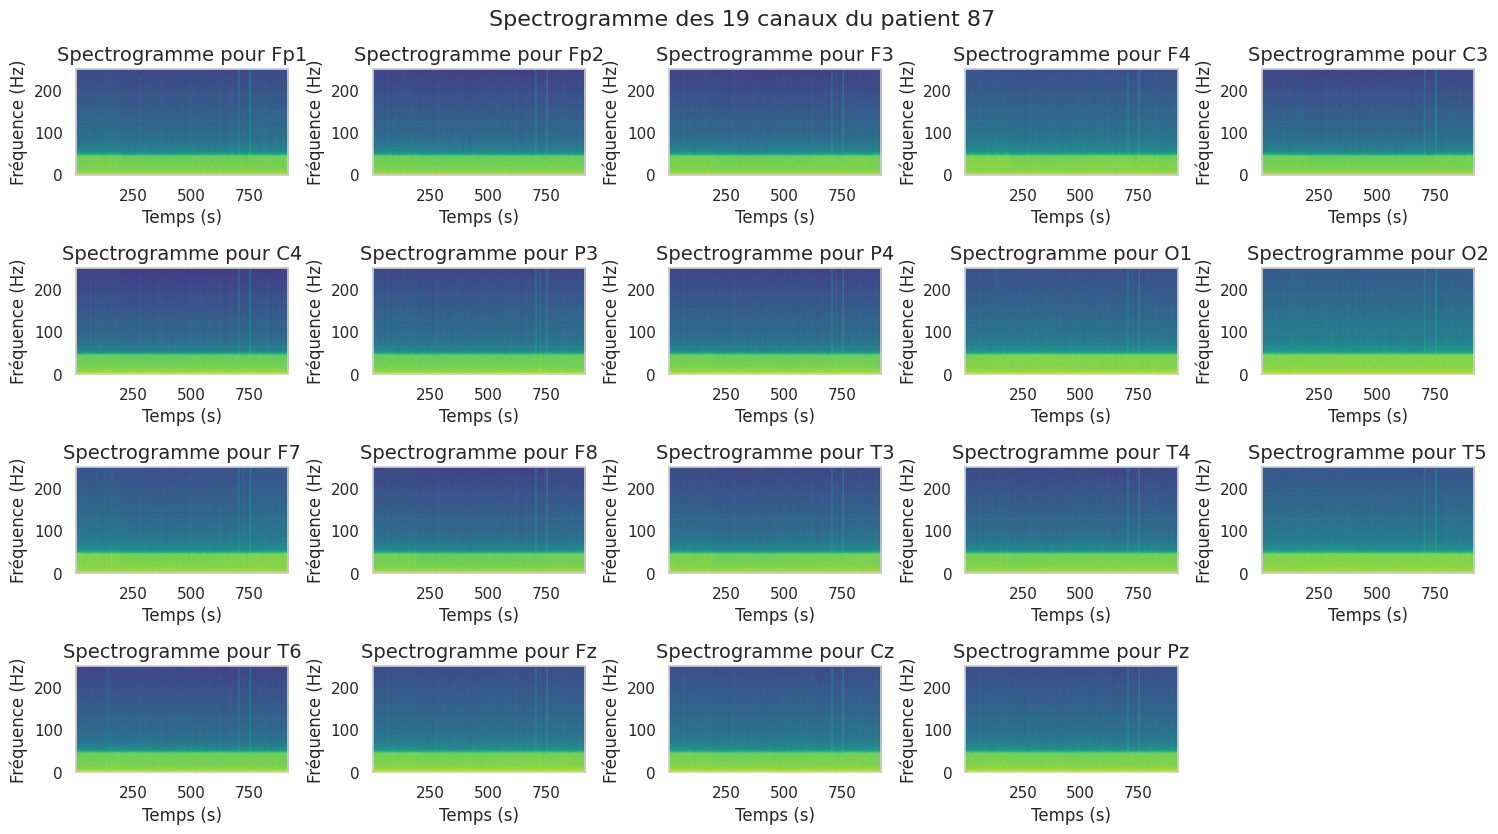

In [17]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram

liste_cmap_col = ['plasma', 'inferno', 'magma', 'cividis', 'Blues', 'Greens', 'Oranges', 'Purples', 'YlGn', 'YlOrBr', 'viridis' ]
couleur = random.choice(liste_cmap_col)

plt.figure(figsize=(15, 10))
num_rows = 5
num_cols = 5
num_subplots = num_rows * num_cols

patient = 87

for i in range(19):
  # Extraction d'un xcanal
  channel_idx = i  # les canaux
  data = liste_de_rats[patient][raw.ch_names[channel_idx]].values
  sfreq = raw.info['sfreq']  # fs
  n_fft = 1024  # fenêtre FFT
  # graphe 5 X 4
  plt.subplot(num_rows, num_cols, i + 1)

  # spectrogramme
  freq, times, Sxx = spectrogram(data, fs=sfreq, nperseg=n_fft)
  plt.imshow(10 * np.log10(Sxx), aspect='auto', origin='lower',
           extent=[times[0], times[-1], freq[0], freq[-1]], cmap='viridis')

  plt.title(f"Spectre pour canal {i}")
  plt.xlabel('Temps (s)', fontsize=12)
  plt.ylabel('Fréquence (Hz)', fontsize=12)
  plt.title(f'Spectrogramme pour {channels[channel_idx]}', fontsize=14)
  plt.grid(False)
plt.suptitle(f"Spectrogramme des 19 canaux du patient {patient}", fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-9-6f85237dc737>:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


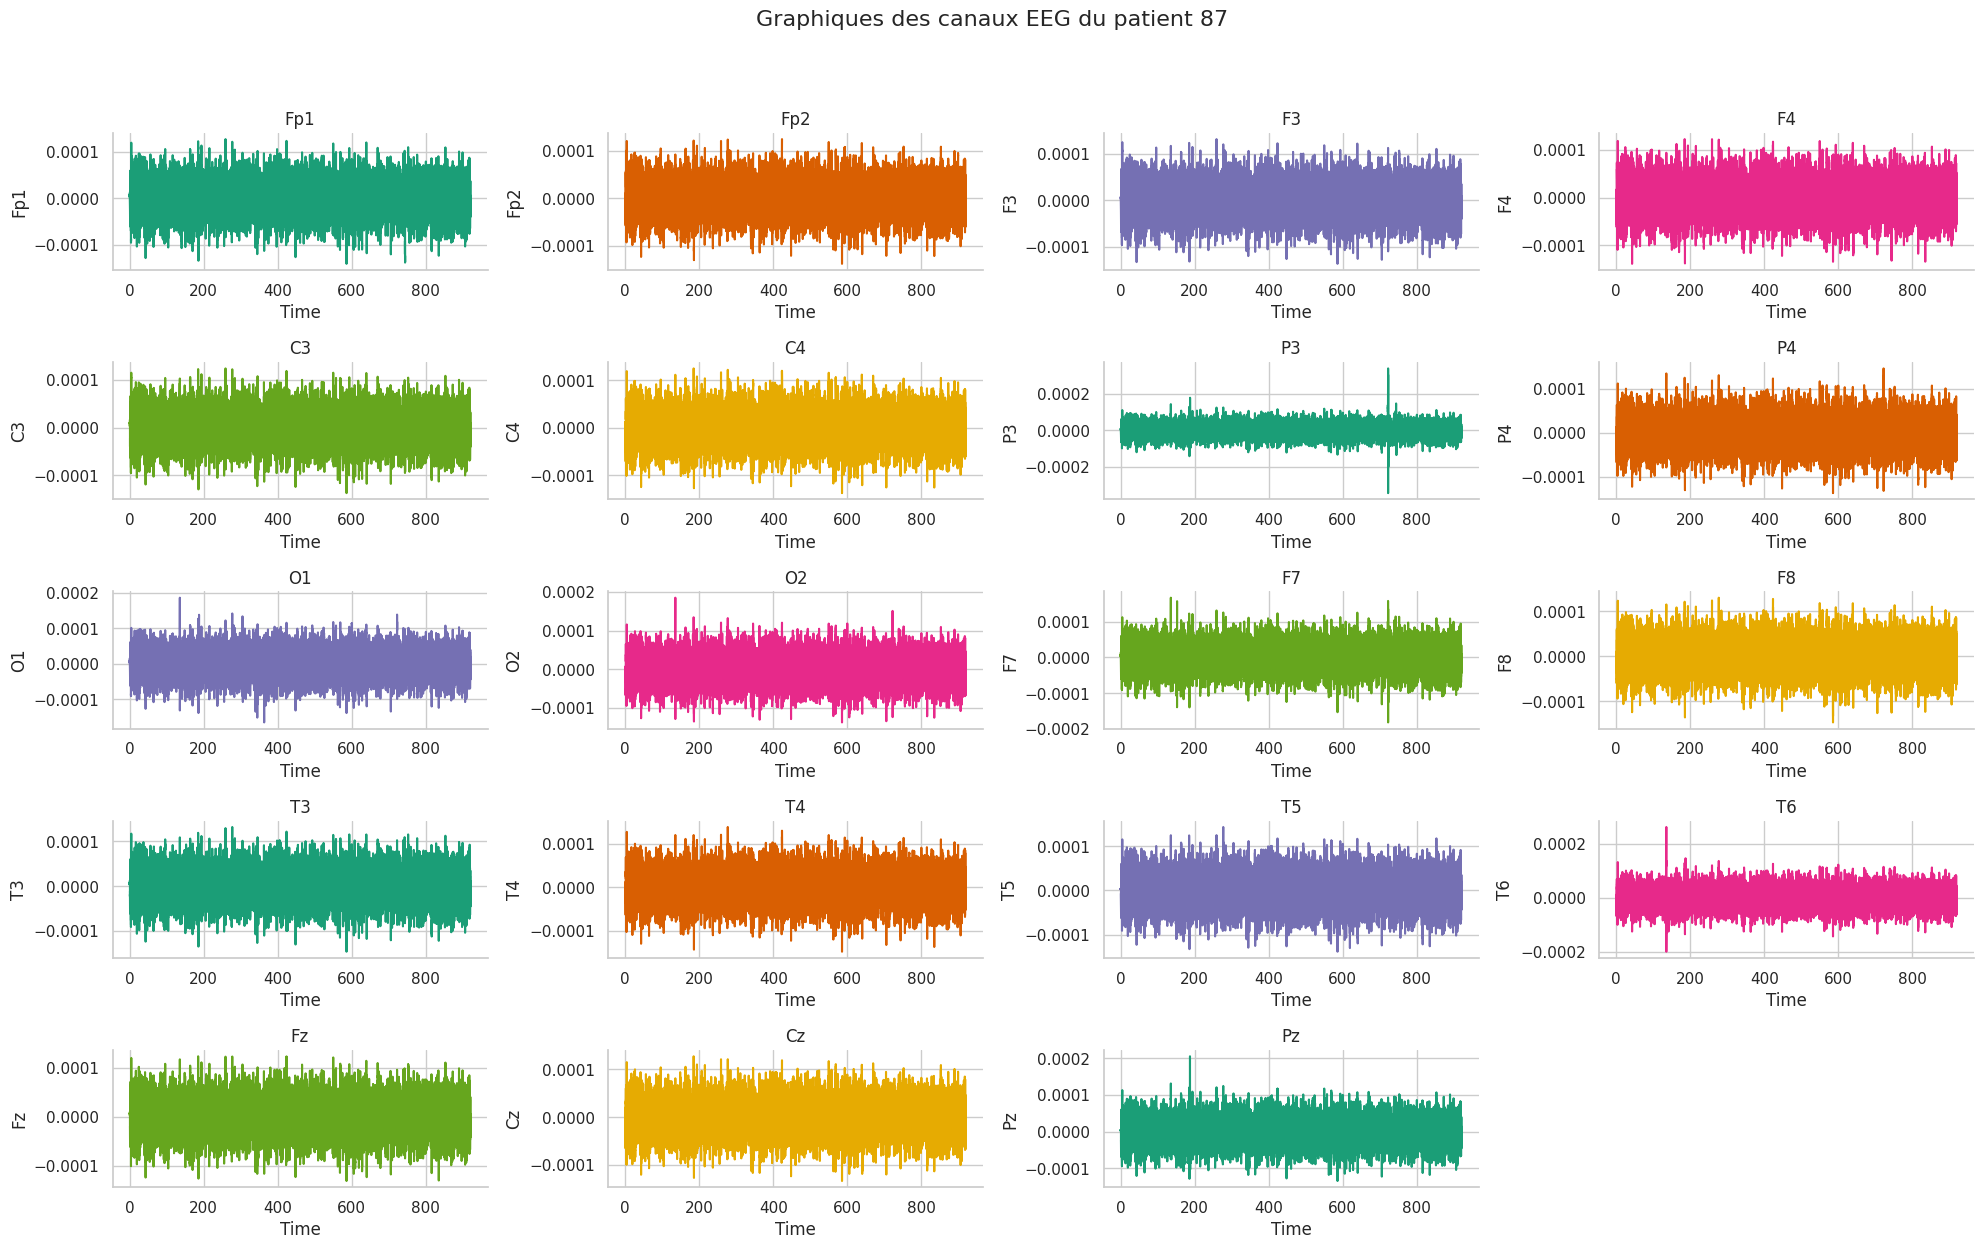

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

patient = 87

# df [0][
# couleur
palette = list(sns.palettes.mpl_palette('Dark2'))
#  canal EEG
def _plot_series(ax, series, series_name, series_index=0):
    xs = series['time']
    ys = series[series_name]
    ax.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])
    ax.set_xlabel('Time')
    ax.set_ylabel(series_name)
    ax.set_title(series_name)

#  6 lignes et 4 colonnes de sous-graphiques
fig, axes = plt.subplots(6, 4, figsize=(20, 15), layout='constrained')
# graphe
for i, feature in enumerate(raw.ch_names):
    row = i // 4
    col = i % 4
    _plot_series(axes[row, col], liste_de_rats[87], feature, series_index=i)
    sns.despine(fig=fig, ax=axes[row, col])

for j in range(len(raw.ch_names), 24):
    fig.delaxes(axes[j // 4, j % 4])

u = 87  # choix de patients 0-87
fig.suptitle(f"Graphiques des canaux EEG du patient {u}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visualisation des spectrogrammes de 19 patients au hasard

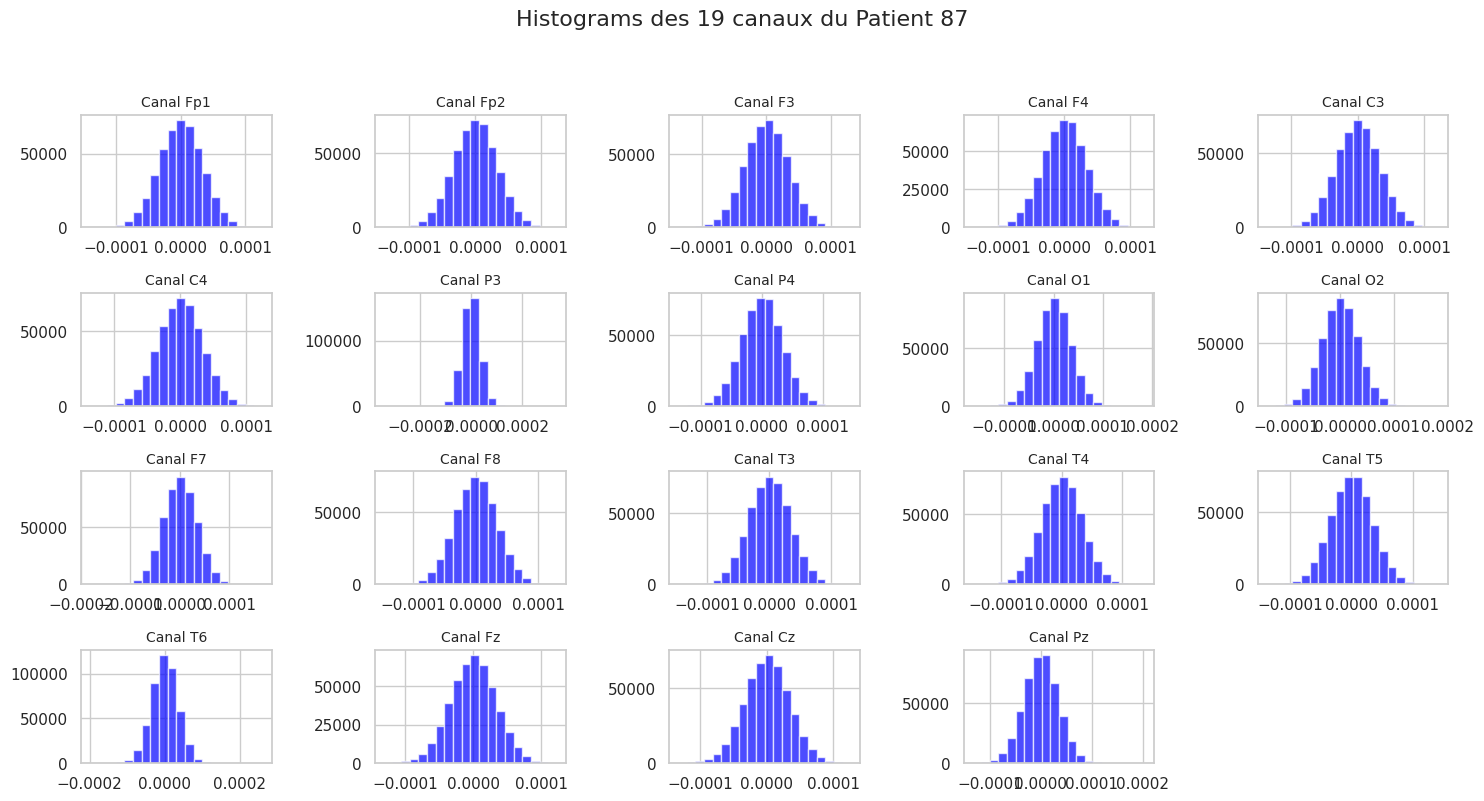

In [26]:
import matplotlib.pyplot as plt

liste_cmap_col = ['plasma', 'inferno', 'magma', 'cividis', 'Blues', 'Greens', 'Oranges', 'Purples', 'YlGn', 'YlOrBr', 'viridis' ]
couleur = random.choice(liste_cmap_col)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

num_rows = 5
num_cols = 5
num_subplots = num_rows * num_cols

patient = 87
axes = axes.flatten()

# Boucle sur les 19 canaux
for j in range(19):
    channel_idx = j
    data = liste_de_rats[patient][raw.ch_names[channel_idx]].values

    # histogramme
    axes[j].hist(data, bins=20, color='blue', alpha=0.7)
    axes[j].set_title(f"Canal {raw.ch_names[channel_idx]}", fontsize=10)

for k in range(19, len(axes)):
    fig.delaxes(axes[k])

plt.suptitle(f"Histograms des 19 canaux du Patient {patient}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

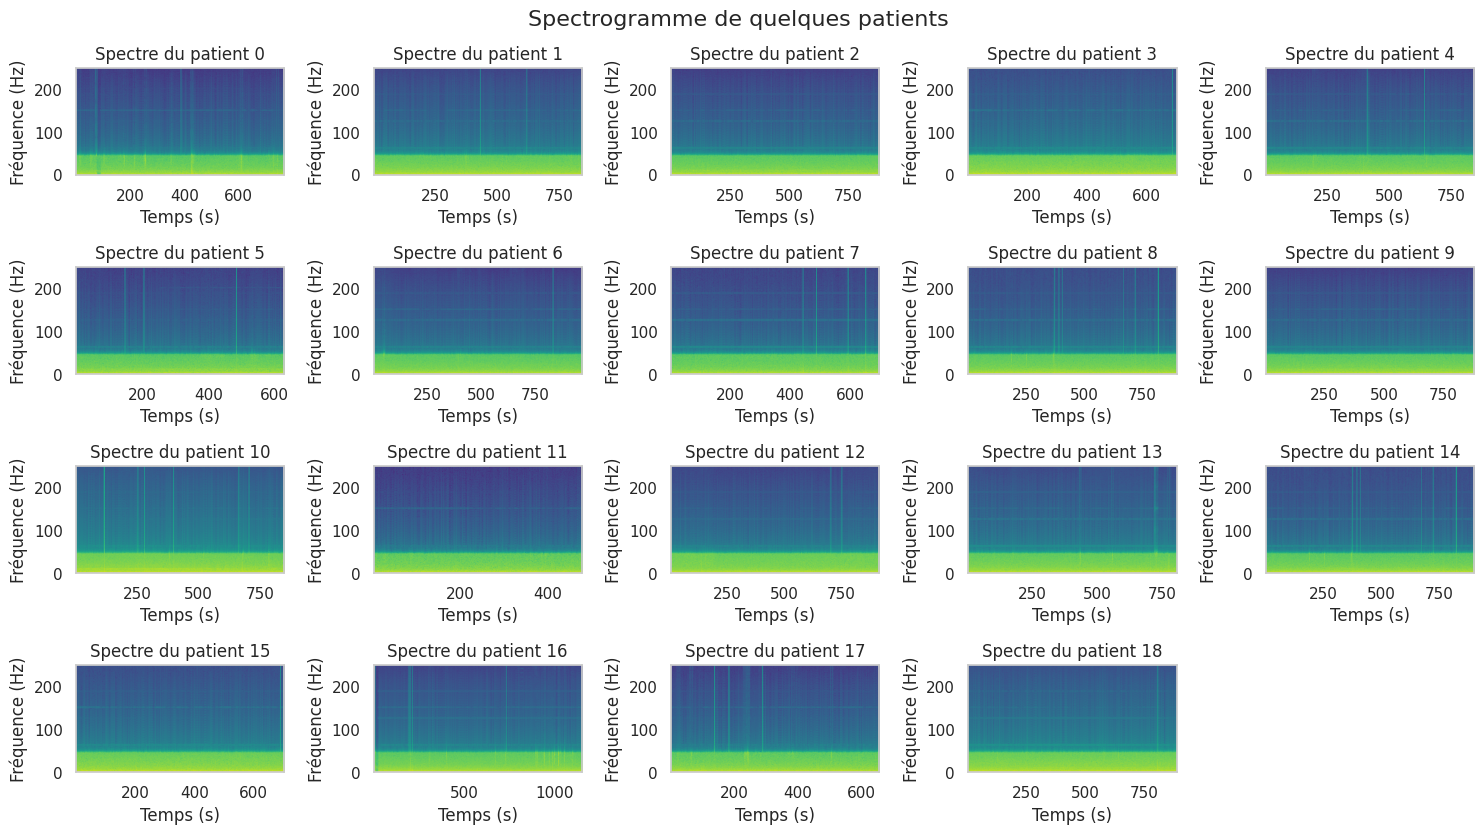

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

plt.figure(figsize=(15, 10))

num_rows = 5
num_cols = 5

num_subplots = num_rows * num_cols

for i in range(19):
  data = random.choice(liste_de_rats)
  all_canaux = np.mean([data[raw.ch_names[k]].values for k in range(19)], axis=0)

  sfreq = raw.info['sfreq']  # fs
  n_fft = 1024  # fenêtre FFT

  # spectrogramme total
  freq, times, Sxx = spectrogram(all_canaux, fs=sfreq, nperseg=n_fft)
  spectrogram_tensor = np.log1p(random.choice(all_spectres))
  spectrogram_tensor = np.log1p(spectrogram_tensor)
  # graphe 5 x 4
  plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(10 * np.log10(Sxx), aspect='auto', origin='lower',
           extent=[times[0], times[-1], freq[0], freq[-1]], cmap='viridis')
  plt.title(f"Spectre du patient {i}")
  plt.xlabel('Temps (s)', fontsize=12)
  plt.ylabel('Fréquence (Hz)', fontsize=12)
  plt.grid(False)
plt.suptitle(f"Spectrogramme de quelques patients ", fontsize=16)
plt.tight_layout()
plt.show()

## Distribution des classes avec 2 ou 3 classes

## Distribution des classes

<ipython-input-14-808e143bfdf4>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 2})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   participant_id    88 non-null     object
 1   Gender            88 non-null     object
 2   Age               88 non-null     int64 
 3   Group             88 non-null     object
 4   MMSE              88 non-null     int64 
 5   Class_norm_anorm  88 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 4.2+ KB
None
Class_norm_anorm
1    36
0    29
2    23
Name: count, dtype: int64


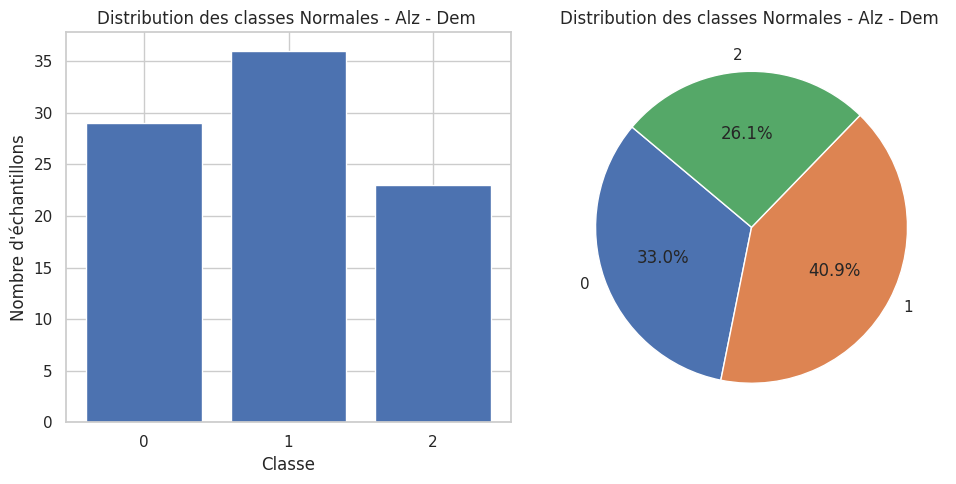

In [14]:
# ======= Rajout de la colonne Classe : 0-1 ou 0-1-2 =============
# 0 - 1 - 1
#participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 1})
# 0 - 1 - 2
participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 2})
#print(participants_data['Class_norm_anorm'])

df_risque_train = participants_data
# info() sur les dataset et les données
print(df_risque_train.info())
# ==============================
# voir le debalancement des classes pour l'entrainement
print(df_risque_train['Class_norm_anorm'].value_counts())

# Affichage nombre de classes par catégorie 0-1
def distribution_bar(ax, df, titre):
    nbr_classe = df['Class_norm_anorm'].value_counts().sort_index()
    ax.bar(nbr_classe.index.astype(str), nbr_classe.values)
    ax.set_xlabel("Classe")
    ax.set_ylabel("Nombre d'échantillons")
    ax.set_title(titre)

# Affichage nombre de classes par catégorie 0-1
def distribution_pie(ax, df, titre):
    nbr_classe = df['Class_norm_anorm'].value_counts().sort_index()
    ax.pie(nbr_classe, labels=nbr_classe.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(titre)
# ==============================
# Visualisation du debalancement de classe
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
distribution_bar(axs[0], df_risque_train, "Distribution des classes Normales - Alz - Dem ")
# graphique pour pie
distribution_pie(axs[1], df_risque_train, "Distribution des classes Normales - Alz - Dem ")
plt.tight_layout()
plt.show()

<ipython-input-20-f382fba4d356>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 1})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   participant_id    88 non-null     object
 1   Gender            88 non-null     object
 2   Age               88 non-null     int64 
 3   Group             88 non-null     object
 4   MMSE              88 non-null     int64 
 5   Class_norm_anorm  88 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 4.2+ KB
None
Class_norm_anorm
1    59
0    29
Name: count, dtype: int64


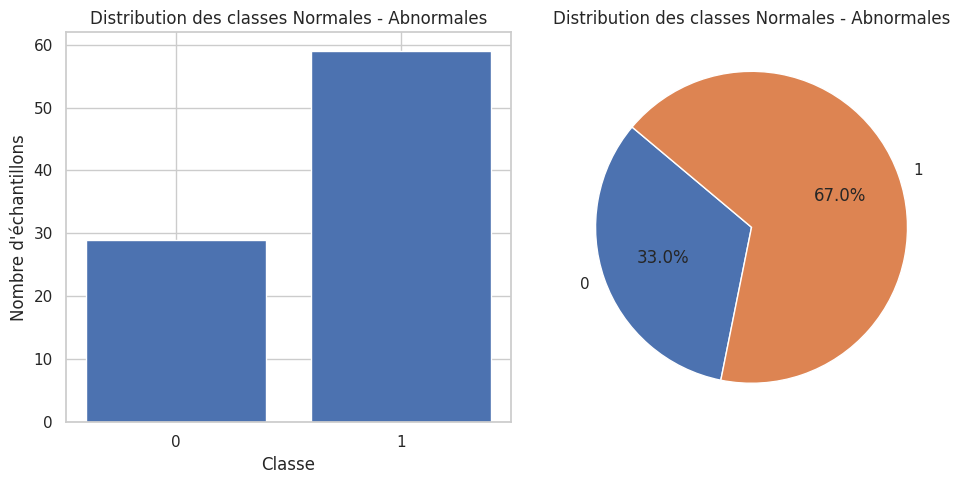

In [20]:
# Petit prétraitement des données
# Analyse et prétraitement des données
# On a deux datasets :
#     participants_data -> info sur les participants
#         liste_de_rats -> les eeg des participants

# ======= Rajout de la colonne Classe : 0-1 ou 0-1-2 =============
# 0 - 1 - 1
participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 1})
# 0 - 1 - 2
#participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 2})
#print(participants_data['Class_norm_anorm'])

df_risque_train = participants_data
# info() sur les dataset et les données
print(df_risque_train.info())
# ==============================
# voir le debalancement des classes pour l'entrainement
print(df_risque_train['Class_norm_anorm'].value_counts())

# Affichage nombre de classes par catégorie 0-1
def distribution_bar(ax, df, titre):
    nbr_classe = df['Class_norm_anorm'].value_counts().sort_index()
    ax.bar(nbr_classe.index.astype(str), nbr_classe.values)
    ax.set_xlabel("Classe")
    ax.set_ylabel("Nombre d'échantillons")
    ax.set_title(titre)

# Affichage nombre de classes par catégorie 0-1
def distribution_pie(ax, df, titre):
    nbr_classe = df['Class_norm_anorm'].value_counts().sort_index()
    ax.pie(nbr_classe, labels=nbr_classe.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(titre)
# ==============================
# Visualisation du debalancement de classe
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
distribution_bar(axs[0], df_risque_train, "Distribution des classes Normales - Abnormales")
# graphique pour pie
distribution_pie(axs[1], df_risque_train, "Distribution des classes Normales - Abnormales")
plt.tight_layout()
plt.show()